In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        # Implement this!, just returns a vector where a_i = 1 if max else 0
        action_values = Q[observation] # this would give me vector of action values
        action_probs = np.zeros_like(action_values)
        action_probs[np.argmax(action_values)] = 1
        return action_probs
    return policy_fn

In [5]:
def make_epsilon_greedy(Q, epsilon, nA):
    def policy_fn(observation):
        action_values = Q[observation]
        action_probs = np.ones(nA)*(epsilon / nA)
        action_probs[np.argmax(action_values)] += (1-epsilon)
        return action_probs
    return policy_fn

In [27]:
def compute_iwd_reward(rewards_list, df, target_prob, behavior_prob):
    discounted_iw_reward = list()
    returns = list()
    for i,r in enumerate(reversed(rewards_list)):
        if i == 0:
            returns.append(r)
            w = target_prob[-1-i] / behavior_prob[-1-i]
            discounted_iw_reward.append(w*r)
        else:
            reward = r + df*returns[-1]
            w = w*(target_prob[-1-i] / behavior_prob[-1-i])
            returns.append(reward)
            discounted_iw_reward.append(w*reward)
    return discounted_iw_reward

In [32]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn, doing every visit monte-carlo
    target_policy = create_greedy_policy(Q)
    visit_counter = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Implement this!
    for i_episode in range(num_episodes):
        # what is the episode number going
        if i_episode % 10000 == 0:
            print("{}/{}".format(i_episode, num_episodes))
        
        observation = env.reset()
        ep_reward = list() # list to store the episode rewards
        visited_sa_pairs = list()
        target_policy_weight = list()
        behavior_policy_weight = list()
        
        # execute this episode
        while True:
            # select action based on the behaviour policy
            action_probs = behavior_policy(observation)
            target_policy_probs = target_policy(observation)
            act = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            behavior_policy_weight.append(action_probs[act])
            target_policy_weight.append(target_policy_probs[act])
            
            # keep track of the states and action visited during the episode.
            visited_sa_pairs.append((observation, act))
            
            # execute the action to get yourself to new state
            observation, reward, done, _ = env.step(act)
            # add the reward to the list of rewards collected during the episode
            ep_reward.append(reward)
            
            # if the episode ends, compute the return(discounted reward), importance sample it
            # then update the Q-value function and finally make the target policy move toward it
            if done:
                returns = compute_iwd_reward(ep_reward, discount_factor, target_policy_weight, behavior_policy_weight)
                # update the Q value function
                for i, sa in enumerate(visited_sa_pairs):
                    s, a = sa
                    visit_counter[s][a] += 1
                    Q[s][a] = Q[s][a] + (1.0/visit_counter[s][a]) * (returns[i] - Q[s][a])
                # finally update the target policy according to the new Q value
                target_policy = create_greedy_policy(Q)
                break
            # episode end.
    return Q, target_policy

In [33]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=50000, behavior_policy=random_policy)

0/50000
10000/50000
20000/50000
30000/50000
40000/50000


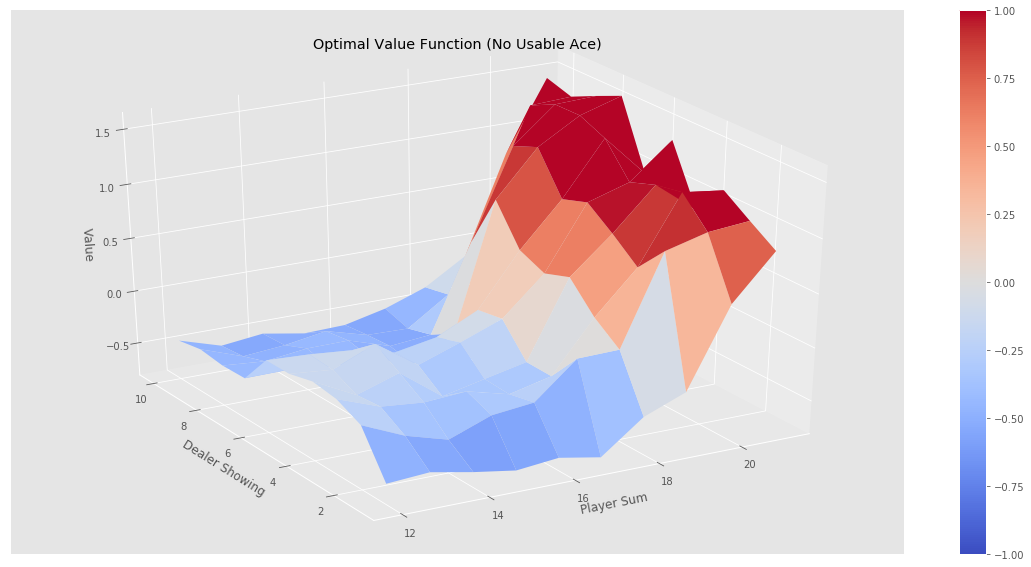

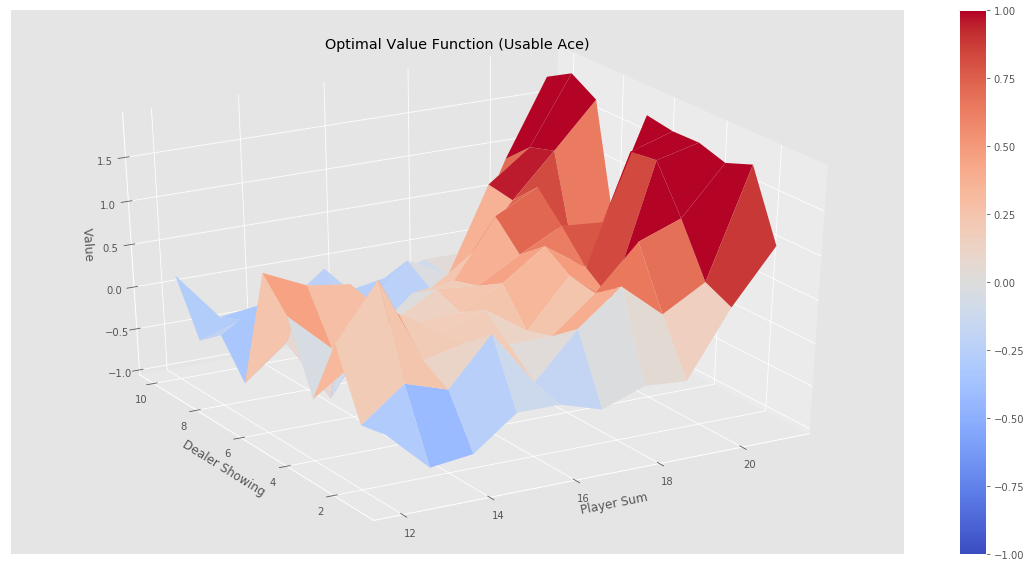

In [34]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")